In [25]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'IPAexGothic', 'Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
#データを整理
df23_24 = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_23-24シーズン.csv')
df24_25 = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_24-25シーズン.csv')
df_box = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】ボックススコア.csv')
df_game = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】試合データ.csv')

#リーグのみ抽出
#リーグの試合IDを抽出
cupID = [500, 507]
df_gameID_cupID = df_game[df_game['カップID'].isin(cupID)]
df_gameID_cupID = df_gameID_cupID['試合ID'].unique()

#試合IDからデータを抽出
df23_24 = df23_24[df23_24['試合ID'].isin(df_gameID_cupID)]
df24_25 = df24_25[df24_25['試合ID'].isin(df_gameID_cupID)]
df_box = df_box[df_box['試合ID'].isin(df_gameID_cupID)]
df_game = df_game[df_game['試合ID'].isin(df_gameID_cupID)]


# 試合ID、チームIDごとにデータを整理
df_box_gameid = df_box.drop(columns=['ホームアウェイ','チーム名','チーム名英','選手ID','背番号','選手名','スターティングフラグ','プレイタイム'])
df_box_gameid_sum = df_box_gameid[df_box_gameid['ピリオド区分'] == 18].groupby(['試合ID','チームID']).sum(numeric_only=True).reset_index()

# 試合IDごとに勝敗を割り当て
# 1. 試合IDごとに得点の最大値を取得
max_scores = df_box_gameid_sum.groupby('試合ID')['得点'].transform('max')
# 2. 自チームの得点が最大なら1（勝ち）、そうでなければ0（負け）
df_box_gameid_sum['勝敗'] = (df_box_gameid_sum['得点'] == max_scores).astype(int)

# 試合データから失点列を作成（より効率的）
df_game_long = pd.concat([
    df_game[['試合ID', 'ホームチームID', 'アウェイ得点']].rename(
        columns={'ホームチームID': 'チームID', 'アウェイ得点': '失点'}
    ),
    df_game[['試合ID', 'アウェイチームID', 'ホーム得点']].rename(
        columns={'アウェイチームID': 'チームID', 'ホーム得点': '失点'}
    )
], ignore_index=True)

# df_box_gameid_sum に失点を結合
df_box_gameid_sum = df_box_gameid_sum.merge(
    df_game_long[['試合ID', 'チームID', '失点']],
    on=['試合ID', 'チームID'],
    how='left'
)

# 安全に成功率を計算するヘルパー
# ...existing code...
def safe_rate(df, num_col, den_col, out_col, fillna=0):
    if num_col not in df.columns or den_col not in df.columns:
        print(f"警告: 列がありません: {num_col} または {den_col}")
        return
    # 数値化（非数値は NaN）
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
    df[den_col] = pd.to_numeric(df[den_col], errors='coerce')
    # 0 を NaN にしてゼロ除算を回避
    denom = df[den_col].replace({0: np.nan})
    # 計算（結果を float に強制）
    df[out_col] = (df[num_col] / denom).astype(float)
    # 数値化の再適用（万が一の非数を排除）
    df[out_col] = pd.to_numeric(df[out_col], errors='coerce')
    # 現実的な範囲に収める（負や 1 より大きい値が出た場合にクリップ）
    df[out_col] = df[out_col].clip(lower=0.0, upper=1.0)
    # オプションで NaN を置換
    if fillna is not None:
        df[out_col] = df[out_col].fillna(fillna)

# 成功率列を安全に作成
safe_rate(df_box_gameid_sum, '2P成功', '2P試投', '2P成功率')
safe_rate(df_box_gameid_sum, '3P成功', '3P試投', '3P成功率')
safe_rate(df_box_gameid_sum, 'フリースロー成功', 'フリースロー試投', 'フリースロー成功率')

In [38]:
#目的変数を'勝敗'としたVIFを計算
df = df_box_gameid_sum.copy()

exp_val = [
    'ブロックショット','ファウル','被ブロックショット','ファストブレイクポイント',
    'アシスト','オフェンスリバウンド','ディフェンスリバウンド','スティール',
    'ターンオーバ','被ファウル','フリースロー成功率','2P成功率','3P成功率'
]

# 列選択（リストで）
x = df[exp_val].copy()

y = df["勝敗"]
x.corr()

vif = np.diag(np.linalg.inv(x.corr().values))
df_vif = pd.DataFrame(vif)
df_vif.columns = ["VIF"]
df_vif.index = x.corr().columns
df_vif.sort_values("VIF")

,VIF
フリースロー成功率,1.014289
ブロックショット,1.035563
被ファウル,1.041216
ターンオーバ,1.058235
ファウル,1.068402
ディフェンスリバウンド,1.100959
被ブロックショット,1.131839
オフェンスリバウンド,1.164396
スティール,1.226424
3P成功率,1.341786


In [52]:
# 標準化したデータ分析
# ===== 標準化（ここが重要）=====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_box_gameid_sum[exp_val])

# 切片追加
X_scaled = sm.add_constant(X_scaled)

# 目的変数
y = df_box_gameid_sum["勝敗"]

# ===== L1正則化付きロジスティック回帰 =====
model = sm.Logit(y, X_scaled)
result = model.fit_regularized(
    method='l1',
    alpha=1,
    maxiter=1000
)


# ===== 結果表示 =====
display(result.summary())

# ===== 標準偏回帰係数を抽出 =====
coef_df = pd.DataFrame({
    '変数': result.params.index,
    '標準偏回帰係数': result.params.values
})



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.32160004544721554
            Iterations: 117
            Function evaluations: 118
            Gradient evaluations: 117


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     勝敗   No. Observations:                 2878
Model:                          Logit   Df Residuals:                     2864
Method:                           MLE   Df Model:                           13
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.5409
Time:                        18:50:35   Log-Likelihood:                -915.94
converged:                       True   LL-Null:                       -1994.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0267      0.059     -0.452      0.651      -0.142       0.089
x1             0.1580      0.060      2.637      0.008       0.041       0.275
x2            -0.6743      0.065    -10.438      0.000      -0.801      -0.548
x3            -0.0034      0.062     -0.055      0.956      -0.126       0.119
x4            -0.1839      0.069     -2.671      0.008      -0.319      -0.049
x5            -0.0243      0.075     -0.323      0.746      -0.171       0.123
x6             0.7414      0.067     11.014      0.000       0.609       0.873
x7             1.5159      0.079     19.273      0.000       1.362       1.670
x8             1.0425      0.075     13.962      0.000       0.896       1.189
x9            -1.0477      0.069    -15.232      0.000      -1.183      -0.913
x10            0.7821      0.065     12.058      0.000       0.655       0.909
x11            0.3662      0.061      6.050      0.000       0.248       0.485
x12            1.3512      0.083     16.269      0.000       1.188       1.514
x13            1.7093      0.088     19.506      0.000       1.538       1.881
==============================================================================
"""

In [48]:
# 標準化した越谷アルファーズのデータ分析
df_alphas = df_box_gameid_sum[df_box_gameid_sum['チームID'] == 745].copy()

# 標準化（ここが重要）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_alphas[exp_val])

# 切片追加
X_scaled = sm.add_constant(X_scaled)

# 目的変数

y = df_alphas["勝敗"]

# ===== L1正則化付きロジスティック回帰 =====
model = sm.Logit(y, X_scaled)
result = model.fit_regularized(
    method='l1',
    alpha=1,
    maxiter=1000
)

# ===== 結果表示 =====
display(result.summary())

# ===== 標準偏回帰係数を抽出 =====
coef_df = pd.DataFrame({
    '変数': ['定数'] + exp_val,
    '標準偏回帰係数': result.params.values
})
display(coef_df)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3444804701120501
            Iterations: 53
            Function evaluations: 53
            Gradient evaluations: 53


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     勝敗   No. Observations:                   60
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                           10
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.6391
Time:                        18:40:20   Log-Likelihood:                -13.519
converged:                       True   LL-Null:                       -37.460
Covariance Type:            nonrobust   LLR p-value:                 6.522e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1422      0.439     -2.605      0.009      -2.002      -0.283
x1                  0        nan        nan        nan         nan         nan
x2            -0.0590      0.482     -0.122      0.903      -1.004       0.886
x3            -0.1981      0.530     -0.374      0.708      -1.237       0.840
x4                  0        nan        nan        nan         nan         nan
x5                  0        nan        nan        nan         nan         nan
x6             0.8785      0.476      1.847      0.065      -0.054       1.811
x7             1.1265      0.503      2.238      0.025       0.140       2.113
x8             0.4554      0.463      0.984      0.325      -0.452       1.363
x9            -0.5933      0.462     -1.284      0.199      -1.499       0.312
x10            1.0353      0.497      2.082      0.037       0.061       2.010
x11            0.0732      0.412      0.178      0.859      -0.734       0.880
x12            0.4302      0.455      0.946      0.344      -0.461       1.322
x13            1.1582      0.561      2.066      0.039       0.060       2.257
==============================================================================
"""

,変数,標準偏回帰係数
0,定数,-1.142193
1,ブロックショット,0.000000
2,ファウル,-0.058974
3,被ブロックショット,-0.198125
4,ファストブレイクポイント,0.000000
5,アシスト,0.000000
6,オフェンスリバウンド,0.878515
7,ディフェンスリバウンド,1.126547
8,スティール,0.455370
9,ターンオーバ,-0.593322


In [ ]:
#Bリーグ全体、L1重回帰回帰を実施、得点を目的変数とする
# --- 説明変数・目的変数 ---
exp_val = [
    '3P試投','2P試投','ダンク','フリースロー試投',
    'ディフェンスリバウンド','オフェンスリバウンド',
    'ターンオーバ','スティール','ブロックショット','被ブロックショット',
    'ファストブレイクポイント','セカンドチャンスポイント','ファウル','被ファウル'
]

X = df[exp_val]
y = df["得点"]

# --- 標準化（Lassoではスケールが重要） ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Lasso回帰 (クロスバリデーション付き) ---
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# --- 結果表示 ---
coef_df = pd.DataFrame({
    "変数": exp_val,
    "係数": lasso.coef_
}).sort_values(by="係数", ascending=False)

print("最適な正則化パラメータ alpha:", lasso.alpha_)

coef_df

最適な正則化パラメータ alpha: 0.004752948248932024


,変数,係数
1,2P試投,5.422935
0,3P試投,5.219532
3,フリースロー試投,4.123555
11,セカンドチャンスポイント,3.514255
10,ファストブレイクポイント,2.734271
2,ダンク,0.746484
4,ディフェンスリバウンド,0.537730
13,被ファウル,0.256246
8,ブロックショット,0.174145
6,ターンオーバ,-0.319638


In [ ]:
#越谷アルファーズ、L1重回帰回帰を実施、得点を目的変数とする
# --- 説明変数・目的変数 ---
exp_val = [
    '3P試投','2P試投','ダンク','フリースロー試投',
    'ディフェンスリバウンド','オフェンスリバウンド',
    'ターンオーバ','スティール','ブロックショット','被ブロックショット',
    'ファストブレイクポイント','セカンドチャンスポイント','ファウル','被ファウル'
]

X = df_alphas[exp_val]
y = df_alphas["得点"]

# --- 標準化（Lassoではスケールが重要） ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Lasso回帰 (クロスバリデーション付き) ---
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# --- 結果表示 ---
coef_df_alphas = pd.DataFrame({
    "変数": exp_val,
    "係数": lasso.coef_
}).sort_values(by="係数", ascending=False)

print("最適な正則化パラメータ alpha:", lasso.alpha_)

coef_df_alphas

#Bリーグ全体、L1重回帰を実施、得点を目的変数とする、リバウンドを説明変数とする
# --- 説明変数・目的変数 ---
exp_val = [
    'ディフェンスリバウンド','オフェンスリバウンド'
]

X = df[exp_val]
y = df["得点"]

# --- 標準化（Lassoではスケールが重要） ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Lasso回帰 (クロスバリデーション付き) ---
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# --- 結果表示 ---
coef_df = pd.DataFrame({
    "変数": exp_val,
    "係数": lasso.coef_
}).sort_values(by="係数", ascending=False)

print("最適な正則化パラメータ alpha:", lasso.alpha_)


coef_df




最適な正則化パラメータ alpha: 0.18121777843164938
最適な正則化パラメータ alpha: 0.002235163130879386


,変数,係数
0,ディフェンスリバウンド,2.149571
1,オフェンスリバウンド,1.167465


In [ ]:
#越谷アルファーズ、L1重回帰を実施、得点を目的変数、リバウンドを説明変数とする
# --- 説明変数・目的変数 ---
exp_val = [
    'ディフェンスリバウンド','オフェンスリバウンド',
]

X = df_alphas[exp_val]
y = df_alphas["得点"]

# --- 標準化（Lassoではスケールが重要） ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Lasso回帰 (クロスバリデーション付き) ---
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# --- 結果表示 ---
coef_df_alphas = pd.DataFrame({
    "変数": exp_val,
    "係数": lasso.coef_
}).sort_values(by="係数", ascending=False)

print("最適な正則化パラメータ alpha:", lasso.alpha_)

最適な正則化パラメータ alpha: 0.004483476551264673


In [ ]:
# チーム全体　標準偏回帰係数を計算
# ===== データ準備 =====

# 説明変数
exp_val = [
    'ブロックショット','ファウル','ダンク','被ブロックショット',
    'ディフェンスリバウンド','スティール','ターンオーバ','ファストブレイクポイント',
    'アシスト','セカンドチャンスポイント','オフェンスリバウンド',
    '被ファウル','3P試投','2P試投',
    '2Pインサイドポイント','フリースロー試投'
]

# ===== 標準化（ここが重要）=====
# 1) 標準化 → 2) DataFrame化（列名とインデックスを戻す）
scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(df_box_gameid_sum[exp_val])
X_scaled = pd.DataFrame(X_scaled_arr, columns=exp_val, index=df_box_gameid_sum.index)

# 切片追加
X_scaled = sm.add_constant(X_scaled)

# 目的変数
y = df_box_gameid_sum["勝敗"]

# ===== L1正則化付きロジスティック回帰 =====
model = sm.Logit(y, X_scaled)
result = model.fit_regularized(
    method='l1',
    alpha=1,
    maxiter=1000
)


# ===== 標準偏回帰係数を抽出 =====
coef_df = pd.DataFrame({
    '変数': ['定数'] + exp_val,
    '標準偏回帰係数': result.params.values
})


# ===== 結果表示 =====
result.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3828009691582793
            Iterations: 141
            Function evaluations: 142
            Gradient evaluations: 141


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     勝敗   No. Observations:                 4704
Model:                          Logit   Df Residuals:                     4687
Method:                           MLE   Df Model:                           16
Date:                Sat, 08 Nov 2025   Pseudo R-squ.:                  0.4511
Time:                        23:04:57   Log-Likelihood:                -1789.6
converged:                       True   LL-Null:                       -3260.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0302      0.042      0.722      0.470      -0.052       0.112
ブロックショット         0.2444      0.043      5.660      0.000       0.160       0.329
ファウル            -0.5272      0.048    -11.099      0.000      -0.620      -0.434
ダンク              0.0301      0.046      0.652      0.514      -0.060       0.120
被ブロックショット       -0.1221      0.045     -2.711      0.007      -0.210      -0.034
ディフェンスリバウンド      1.4827      0.058     25.650      0.000       1.369       1.596
スティール            0.9388      0.053     17.822      0.000       0.836       1.042
ターンオーバ          -1.1561      0.057    -20.449      0.000      -1.267      -1.045
ファストブレイクポイント     0.0376      0.053      0.708      0.479      -0.066       0.142
アシスト             0.9773      0.055     17.696      0.000       0.869       1.086
セカンドチャンスポイント     0.6186      0.062      9.917      0.000       0.496       0.741
オフェンスリバウンド       0.4326      0.069      6.252      0.000       0.297       0.568
被ファウル            0.7591      0.074     10.197      0.000       0.613       0.905
3P試投            -1.1179      0.073    -15.274      0.000      -1.261      -0.974
2P試投            -1.5897      0.093    -17.122      0.000      -1.772      -1.408
2Pインサイドポイント      0.5970      0.066      9.047      0.000       0.468       0.726
フリースロー試投        -0.4386      0.078     -5.639      0.000      -0.591      -0.286
================================================================================
"""

In [ ]:
#目的変数を'勝敗'としたVIFを計算
df = df_box_gameid_sum.copy()

y = df["勝敗"]
x = df.drop(['ピリオド区分', 'チームID', '試合ID',"勝敗", '得点', 'トータルリバウンド','フリースロー成功','2P成功','3P成功'], axis=1)

x.corr()

vif = np.diag(np.linalg.inv(x.corr().values))
df_vif = pd.DataFrame(vif)
df_vif.columns = ["VIF"]
df_vif.index = x.corr().columns
df_vif.sort_values("VIF")

,VIF
ブロックショット,1.057173
被ブロックショット,1.160882
ファウル,1.192618
ダンク,1.202836
アシスト,1.421447
ファストブレイクポイント,1.562260
スティール,1.719014
ターンオーバ,1.896733
セカンドチャンスポイント,2.070138
ディフェンスリバウンド,2.174326


In [ ]:
# アルファーズ標準偏回帰係数を計算　成功の説明変数を削除　11/8
# 説明変数
exp_val = [
    'ブロックショット','ファウル','ダンク','被ブロックショット',
    'ディフェンスリバウンド','スティール','ターンオーバ','ファストブレイクポイント',
    'アシスト','セカンドチャンスポイント','オフェンスリバウンド',
    '被ファウル','3P試投','2P試投','2Pインサイドポイント','フリースロー試投'
]

df_alphas = df_box_gameid_sum[df_box_gameid_sum['チームID'] == 745].copy()
y = df_alphas["勝敗"]

# 1) 標準化 → 2) DataFrame化（列名とインデックスを戻す）
scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(df_alphas[exp_val])
X_scaled = pd.DataFrame(X_scaled_arr, columns=exp_val, index=df_alphas.index)

# 3) 定数項を追加（DataFrameのまま）
X_sm = sm.add_constant(X_scaled, has_constant='add')

# 4) ロジスティック回帰（L1）
model = sm.Logit(y, X_sm)
result = model.fit_regularized(method='l1', alpha=1, maxiter=1000)

# 係数表（列名が維持される）
coef_df = pd.DataFrame({
    '変数': result.params.index,   # ← 'const' 含む真の名前
    '標準偏回帰係数': result.params.values
})
result.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3389447655955086
            Iterations: 85
            Function evaluations: 86
            Gradient evaluations: 85


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     勝敗   No. Observations:                  126
Model:                          Logit   Df Residuals:                      111
Method:                           MLE   Df Model:                           14
Date:                Sun, 09 Nov 2025   Pseudo R-squ.:                  0.6307
Time:                        22:28:44   Log-Likelihood:                -32.109
converged:                       True   LL-Null:                       -86.939
Covariance Type:            nonrobust   LLR p-value:                 6.510e-17
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1574      0.289     -0.545      0.586      -0.724       0.409
ブロックショット        -0.2158      0.318     -0.679      0.497      -0.839       0.408
ファウル            -0.4250      0.352     -1.207      0.228      -1.115       0.265
ダンク             -0.0035      0.296     -0.012      0.990      -0.583       0.576
被ブロックショット       -0.1696      0.336     -0.504      0.614      -0.829       0.490
ディフェンスリバウンド      2.0517      0.469      4.374      0.000       1.132       2.971
スティール            1.2331      0.376      3.278      0.001       0.496       1.970
ターンオーバ          -0.7477      0.369     -2.027      0.043      -1.471      -0.025
ファストブレイクポイント          0        nan        nan        nan         nan         nan
アシスト             0.6789      0.423      1.603      0.109      -0.151       1.509
セカンドチャンスポイント     0.6098      0.494      1.234      0.217      -0.359       1.578
オフェンスリバウンド       0.6754      0.580      1.165      0.244      -0.461       1.811
被ファウル            0.9595      0.365      2.627      0.009       0.244       1.675
3P試投            -0.4704      0.475     -0.990      0.322      -1.402       0.461
2P試投            -1.4781      0.645     -2.293      0.022      -2.742      -0.215
2Pインサイドポイント      0.7221      0.529      1.365      0.172      -0.314       1.759
フリースロー試投              0        nan        nan        nan         nan         nan
================================================================================
"""

In [57]:
# 全体のデータを分析
# ===== 標準化したデータ分析 =====
# 1) 標準化（DataFrameで列名保持）
scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(df_box_gameid_sum[exp_val])
X_scaled = pd.DataFrame(X_scaled_arr, columns=exp_val, index=df_box_gameid_sum.index)

# 2) 定数項を追加（DataFrameのまま）
X_scaled = sm.add_constant(X_scaled, has_constant='add')

# 3) 目的変数
y = df_box_gameid_sum["勝敗"]

# 4) L1正則化付きロジスティック回帰
model = sm.Logit(y, X_scaled)
result = model.fit_regularized(
    method='l1',
    alpha=1,
    maxiter=1000
)

# 5) 結果表示
display(result.summary())

# 6) 標準偏回帰係数を抽出（列名維持）
coef_df = pd.DataFrame({
    '変数': result.params.index,
    '標準偏回帰係数': result.params.values
})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40457271953742524
            Iterations: 126
            Function evaluations: 126
            Gradient evaluations: 126


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     勝敗   No. Observations:                 2878
Model:                          Logit   Df Residuals:                     2861
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.4214
Time:                        18:54:05   Log-Likelihood:                -1154.2
converged:                       True   LL-Null:                       -1994.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0174      0.052      0.336      0.737      -0.084       0.119
ブロックショット         0.1790      0.053      3.363      0.001       0.075       0.283
ファウル            -0.4846      0.058     -8.344      0.000      -0.598      -0.371
ダンク             -0.0413      0.056     -0.736      0.462      -0.151       0.069
被ブロックショット       -0.0649      0.055     -1.172      0.241      -0.173       0.044
ディフェンスリバウンド      1.3792      0.070     19.701      0.000       1.242       1.516
スティール            0.9270      0.065     14.200      0.000       0.799       1.055
ターンオーバ          -1.1199      0.070    -16.092      0.000      -1.256      -0.984
ファストブレイクポイント     0.0271      0.064      0.421      0.673      -0.099       0.153
アシスト             0.8690      0.066     13.143      0.000       0.739       0.999
セカンドチャンスポイント     0.6399      0.076      8.442      0.000       0.491       0.789
オフェンスリバウンド       0.3299      0.085      3.884      0.000       0.163       0.496
被ファウル            0.6999      0.088      7.940      0.000       0.527       0.873
3P試投            -1.0043      0.090    -11.127      0.000      -1.181      -0.827
2P試投            -1.4750      0.114    -12.935      0.000      -1.699      -1.252
2Pインサイドポイント      0.5564      0.077      7.191      0.000       0.405       0.708
フリースロー試投        -0.3409      0.092     -3.689      0.000      -0.522      -0.160
================================================================================
"""

In [ ]:
# 使ってない
# チーム全体　標準偏回帰係数を計算　成功の説明変数を削除　11/8
# 説明変数　　
exp_val = [
    'ブロックショット','ファウル','ダンク','被ブロックショット',
    'ディフェンスリバウンド','スティール','ターンオーバ','ファストブレイクポイント',
    'アシスト','セカンドチャンスポイント','オフェンスリバウンド',
    '被ファウル','3P試投','2P試投','2Pインサイドポイント','フリースロー試投'
]

y = df_box_gameid_sum["勝敗"]

# 1) 標準化 → 2) DataFrame化（列名とインデックスを戻す）
scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(df_box_gameid_sum[exp_val])
X_scaled = pd.DataFrame(X_scaled_arr, columns=exp_val, index=df_box_gameid_sum.index)

# 3) 定数項を追加（DataFrameのまま）
X_sm = sm.add_constant(X_scaled, has_constant='add')

# 4) ロジスティック回帰（L1）
model = sm.Logit(y, X_sm)
result = model.fit_regularized(method='l1', alpha=1, maxiter=1000)

# 係数表（列名が維持される）
coef_df = pd.DataFrame({
    '変数': result.params.index,   # ← 'const' 含む真の名前
    '標準偏回帰係数': result.params.values
})
result.summary()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3828009691582793
            Iterations: 141
            Function evaluations: 142
            Gradient evaluations: 141


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     勝敗   No. Observations:                 4704
Model:                          Logit   Df Residuals:                     4687
Method:                           MLE   Df Model:                           16
Date:                Sun, 09 Nov 2025   Pseudo R-squ.:                  0.4511
Time:                        22:28:50   Log-Likelihood:                -1789.6
converged:                       True   LL-Null:                       -3260.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0302      0.042      0.722      0.470      -0.052       0.112
ブロックショット         0.2444      0.043      5.660      0.000       0.160       0.329
ファウル            -0.5272      0.048    -11.099      0.000      -0.620      -0.434
ダンク              0.0301      0.046      0.652      0.514      -0.060       0.120
被ブロックショット       -0.1221      0.045     -2.711      0.007      -0.210      -0.034
ディフェンスリバウンド      1.4827      0.058     25.650      0.000       1.369       1.596
スティール            0.9388      0.053     17.822      0.000       0.836       1.042
ターンオーバ          -1.1561      0.057    -20.449      0.000      -1.267      -1.045
ファストブレイクポイント     0.0376      0.053      0.708      0.479      -0.066       0.142
アシスト             0.9773      0.055     17.696      0.000       0.869       1.086
セカンドチャンスポイント     0.6186      0.062      9.917      0.000       0.496       0.741
オフェンスリバウンド       0.4326      0.069      6.252      0.000       0.297       0.568
被ファウル            0.7591      0.074     10.197      0.000       0.613       0.905
3P試投            -1.1179      0.073    -15.274      0.000      -1.261      -0.974
2P試投            -1.5897      0.093    -17.122      0.000      -1.772      -1.408
2Pインサイドポイント      0.5970      0.066      9.047      0.000       0.468       0.726
フリースロー試投        -0.4386      0.078     -5.639      0.000      -0.591      -0.286
================================================================================
"""

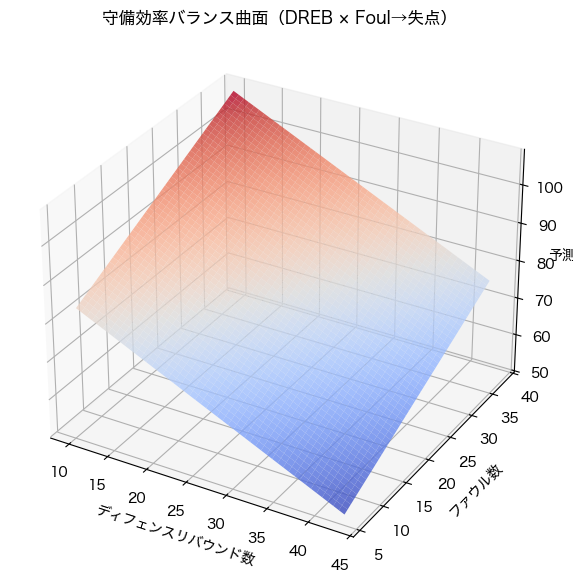

,変数,偏回帰係数
0,const,79.470026
1,ディフェンスリバウンド,-4.634531
2,ファウル,3.053722


In [ ]:
# ===== データ準備 =====
# 説明変数と目的変数
X = df_box_gameid_sum[["ディフェンスリバウンド", "ファウル"]]
y = df_box_gameid_sum["失点"]

# 標準化（単位を揃える）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 回帰モデル（線形）
X_sm = sm.add_constant(X_scaled)
model = sm.OLS(y, X_sm).fit()

# ===== 予測用グリッド作成 =====
drebs = np.linspace(X["ディフェンスリバウンド"].min(), X["ディフェンスリバウンド"].max(), 50)
fouls = np.linspace(X["ファウル"].min(), X["ファウル"].max(), 50)
D, F = np.meshgrid(drebs, fouls)

# 標準化と同じスケールに変換
D_scaled = (D - X["ディフェンスリバウンド"].mean()) / X["ディフェンスリバウンド"].std()
F_scaled = (F - X["ファウル"].mean()) / X["ファウル"].std()

# モデルによる失点予測
Z = (model.params["const"] +
     model.params["ディフェンスリバウンド"] * D_scaled +
     model.params["ファウル"] * F_scaled)

# ===== 3D曲面プロット =====
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(D, F, Z, cmap="coolwarm", alpha=0.8)

ax.set_xlabel("ディフェンスリバウンド数")
ax.set_ylabel("ファウル数")
ax.set_zlabel("予測失点")
ax.set_title("守備効率バランス曲面（DREB × Foul→失点）")
plt.show()

coef_df = pd.DataFrame({
     '変数': model.params.index,
     '偏回帰係数': model.params.values
})
coef_df

In [ ]:
coef_df

,変数,偏回帰係数
0,const,79.470026
1,ディフェンスリバウンド,-4.634531
2,ファウル,3.053722


=== 生スケール係数 ===
            変数  係数(生スケール)            p値
0        const  95.904416  1.927701e-29
1  ディフェンスリバウンド  -1.188048  2.134159e-10
2         ファウル   0.640796  2.041983e-03

=== Xのみ標準化係数 ===
            変数  係数(Xのみ標準化)
0        const   78.293651
1  ディフェンスリバウンド   -5.968879
2         ファウル    2.715949

=== 真の標準偏回帰係数(β) ===
            変数  標準偏回帰係数(β)
0  ディフェンスリバウンド   -0.510842
1         ファウル    0.232443


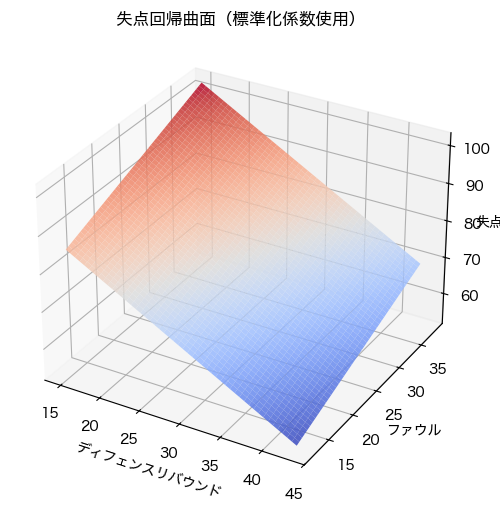

In [ ]:
# ...existing code...

# 対象データ（アルファーズ失点回帰）
X_raw = df_alphas[["ディフェンスリバウンド","ファウル"]]
y_raw = df_alphas["失点"]

# 1) 生データで回帰（1単位増の影響）
model_raw = sm.OLS(y_raw, sm.add_constant(X_raw)).fit()
coef_raw = pd.DataFrame({
    "変数": model_raw.params.index,
    "係数(生スケール)": model_raw.params.values,
    "p値": model_raw.pvalues.values
})

# 2) 説明変数のみ標準化
scaler_x = StandardScaler()
X_std = pd.DataFrame(scaler_x.fit_transform(X_raw), columns=X_raw.columns, index=X_raw.index)
model_xstd = sm.OLS(y_raw, sm.add_constant(X_std)).fit()
coef_xstd = pd.DataFrame({
    "変数": model_xstd.params.index,
    "係数(Xのみ標準化)": model_xstd.params.values
})

# 3) 真の標準偏回帰係数 β の計算（y も標準化した場合と同値）
sd_y = y_raw.std()
beta_true = model_raw.params.copy()
beta_true["ディフェンスリバウンド"] = model_raw.params["ディフェンスリバウンド"] * (X_raw["ディフェンスリバウンド"].std()/sd_y)
beta_true["ファウル"] = model_raw.params["ファウル"] * (X_raw["ファウル"].std()/sd_y)
# 定数項βは通常解釈しない
coef_beta = pd.DataFrame({
    "変数": ["ディフェンスリバウンド","ファウル"],
    "標準偏回帰係数(β)": [beta_true["ディフェンスリバウンド"], beta_true["ファウル"]]
})

# 4) まとめ
print("=== 生スケール係数 ===")
print(coef_raw)
print("\n=== Xのみ標準化係数 ===")
print(coef_xstd)
print("\n=== 真の標準偏回帰係数(β) ===")
print(coef_beta)

# 5) 3D曲面は X_std を使うなら以下で統一
drebs_grid = np.linspace(X_raw["ディフェンスリバウンド"].min(), X_raw["ディフェンスリバウンド"].max(), 50)
fouls_grid = np.linspace(X_raw["ファウル"].min(), X_raw["ファウル"].max(), 50)
Dg, Fg = np.meshgrid(drebs_grid, fouls_grid)

Dg_std = (Dg - X_raw["ディフェンスリバウンド"].mean())/X_raw["ディフェンスリバウンド"].std()
Fg_std = (Fg - X_raw["ファウル"].mean())/X_raw["ファウル"].std()

Z_pred = (model_xstd.params["const"] +
          model_xstd.params["ディフェンスリバウンド"] * Dg_std +
          model_xstd.params["ファウル"] * Fg_std)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Dg, Fg, Z_pred, cmap="coolwarm", alpha=0.85)
ax.set_xlabel("ディフェンスリバウンド")
ax.set_ylabel("ファウル")
ax.set_zlabel("失点予測")
ax.set_title("失点回帰曲面（標準化係数使用）")
plt.show()

# ...existing code...

In [ ]:
coef_xstd

,変数,係数(Xのみ標準化)
0,const,78.293651
1,ディフェンスリバウンド,-5.968879
2,ファウル,2.715949


In [ ]:
# ...existing code...

# ===== 係数の単純比較を可能にする共通スケール設定 =====
vars_ = ["ディフェンスリバウンド", "ファウル"]

# データ準備
X_all_raw = df_box_gameid_sum[vars_]
y_all = df_box_gameid_sum["失点"]

# チーム抽出（既に df_alphas がある場合は再利用）
df_alphas = df_box_gameid_sum[df_box_gameid_sum["チームID"] == 745].copy()
X_alpha_raw = df_alphas[vars_]
y_alpha = df_alphas["失点"]

# 方法A: 全体でfitしたScalerでXのみグローバル標準化 → OLS
scaler_global = StandardScaler().fit(X_all_raw)

X_all_std = pd.DataFrame(
    scaler_global.transform(X_all_raw),
    columns=vars_, index=X_all_raw.index
)
X_alpha_std = pd.DataFrame(
    scaler_global.transform(X_alpha_raw),
    columns=vars_, index=X_alpha_raw.index
)

m_all_std = sm.OLS(y_all, sm.add_constant(X_all_std)).fit()
m_alpha_std = sm.OLS(y_alpha, sm.add_constant(X_alpha_std)).fit()
sdX_all = X_all_raw.std()

comp_A = pd.DataFrame({
    "変数": ["const"] + vars_,
    "全体(係数: 全体X基準1SDあたり点)": m_all_std.params.values,
    "アルファーズ(係数: 全体X基準1SDあたり点)": m_alpha_std.params.values,
    "全体X_SD": [np.nan] + [sdX_all[v] for v in vars_]
})
comp_A["差(アルファーズ-全体)"] = comp_A["アルファーズ(係数: 全体X基準1SDあたり点)"] - comp_A["全体(係数: 全体X基準1SDあたり点)"]

print("=== 方法A: 共通(全体)X標準化での係数比較（全体XのSDを含む） ===")
display(comp_A)

# 方法B: 完全標準化（Xとyを全体SDでスケーリング）相当の係数
# beta_global = b_raw * sd_X_global / sd_Y_global
sdY_global = y_all.std()
sdX_global = X_all_raw.std()

m_all_raw = sm.OLS(y_all, sm.add_constant(X_all_raw)).fit()
m_alpha_raw = sm.OLS(y_alpha, sm.add_constant(X_alpha_raw)).fit()

beta_all = {}
beta_alpha = {}
for v in vars_:
    beta_all[v] = m_all_raw.params[v] * (sdX_global[v] / sdY_global)
    beta_alpha[v] = m_alpha_raw.params[v] * (sdX_global[v] / sdY_global)

comp_B = pd.DataFrame({
    "変数": vars_,
    "全体(beta: 全体SD基準の無次元)": [beta_all[v] for v in vars_],
    "アルファーズ(beta: 全体SD基準の無次元)": [beta_alpha[v] for v in vars_]
})
comp_B["差(アルファーズ-全体)"] = comp_B["アルファーズ(beta: 全体SD基準の無次元)"] - comp_B["全体(beta: 全体SD基準の無次元)"]

print("=== 方法B: 完全標準化(beta, 全体SD基準)での係数比較 ===")
display(comp_B)

=== 方法A: 共通(全体)X標準化での係数比較（全体XのSDを含む） ===


,変数,全体(係数: 全体X基準1SDあたり点),アルファーズ(係数: 全体X基準1SDあたり点),全体X_SD,差(アルファーズ-全体)
0,const,79.470026,79.471617,NaN,0.001591
1,ディフェンスリバウンド,-4.634531,-5.628793,4.738352,-0.994262
2,ファウル,3.053722,2.518848,3.931230,-0.534874


=== 方法B: 完全標準化(beta, 全体SD基準)での係数比較 ===


,変数,全体(beta: 全体SD基準の無次元),アルファーズ(beta: 全体SD基準の無次元),差(アルファーズ-全体)
0,ディフェンスリバウンド,-0.391490,-0.475478,-0.083988
1,ファウル,0.257955,0.212773,-0.045182


=== 解析解（モデル上の臨界点） ===
scaled_opt = [18.3096, -20.1594] (標準化スケール)
real_opt   = DREB 110.84, Foul -60.22 (元スケール)
解析解上の予測失点 = 5.32

=== グリッド探索（観測範囲内） ===
DREB_opt(grid) = 43.00
Foul_opt(grid) = 6.00
予測最小失点(grid) = 53.06

解析解は観測範囲外です。観測範囲内のグリッド最小点にフォールバックしました。
最終採用点がグリッド境界上ですか？ True


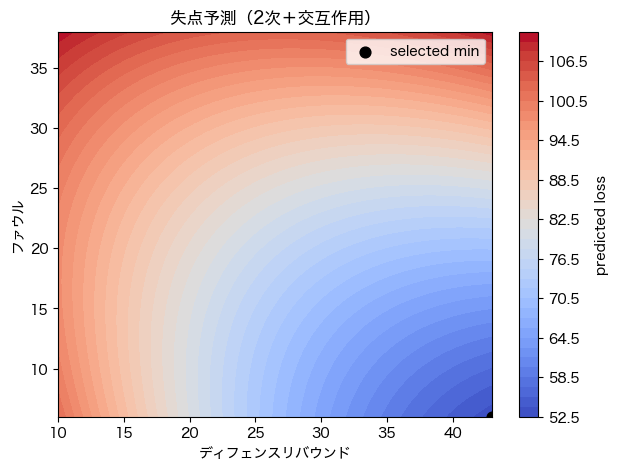

,method,DREB_opt,Foul_opt,predicted_loss,analytic_pred,grid_pred,analytic_in_range,boundary
0,grid,43.0,6.0,53.064971,5.316375,53.064971,False,True


In [ ]:
# ...existing code...
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ===== データ準備 =====
X = df_box_gameid_sum[["ディフェンスリバウンド", "ファウル"]].copy()
y = df_box_gameid_sum["失点"]

# 標準化
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ===== 2次項と交互作用を追加 =====
X_scaled["DREB^2"] = X_scaled["ディフェンスリバウンド"] ** 2
X_scaled["Foul^2"] = X_scaled["ファウル"] ** 2
X_scaled["DREB×Foul"] = X_scaled["ディフェンスリバウンド"] * X_scaled["ファウル"]

# 定数項追加
X_sm = sm.add_constant(X_scaled)
model_quad = sm.OLS(y, X_sm).fit()

# ===== 係数抽出（存在チェック） =====
params = model_quad.params
def p(name):
    return params.get(name, 0.0)

a = p("DREB^2")
b = p("ディフェンスリバウンド")
c = p("Foul^2")
d = p("ファウル")
e = p("DREB×Foul")
const = p("const")

# ===== 最適点を解析的に求める =====
# 行列 A が特異になり得るので安定化して解く
A = np.array([[2*a, e], [e, 2*c]])
B = np.array([-b, -d])

# 数値的安定性チェック
detA = np.linalg.det(A)
if np.isnan(detA) or abs(detA) < 1e-8:
    # 特異またはほぼ特異 → 疑似逆で解く
    opt_scaled = np.linalg.pinv(A) @ B
    warning_msg = "A 行列が特異／ほぼ特異のため疑似逆で解きました"
else:
    opt_scaled = np.linalg.solve(A, B)
    warning_msg = None

# 元スケールへ変換（列順を明示的に対応）
mean_map = dict(zip(X.columns, scaler.mean_))
scale_map = dict(zip(X.columns, scaler.scale_))
opt_real = np.array([
    opt_scaled[0] * scale_map["ディフェンスリバウンド"] + mean_map["ディフェンスリバウンド"],
    opt_scaled[1] * scale_map["ファウル"] + mean_map["ファウル"]
])

print("=== 解析解（モデル上の臨界点） ===")
if warning_msg:
    print("WARNING:", warning_msg)
print(f"scaled_opt = [{opt_scaled[0]:.4f}, {opt_scaled[1]:.4f}] (標準化スケール)")
print(f"real_opt   = DREB {opt_real[0]:.2f}, Foul {opt_real[1]:.2f} (元スケール)")

# ===== 最小失点予測値（解析解上） =====
Z_min_analytic = (const
         + a*opt_scaled[0]**2
         + b*opt_scaled[0]
         + c*opt_scaled[1]**2
         + d*opt_scaled[1]
         + e*opt_scaled[0]*opt_scaled[1])
print(f"解析解上の予測失点 = {Z_min_analytic:.2f}")

# ===== 実測範囲内でメッシュを作成（グリッド探索） =====
drebs = np.linspace(X["ディフェンスリバウンド"].min(), X["ディフェンスリバウンド"].max(), 200)
fouls = np.linspace(X["ファウル"].min(), X["ファウル"].max(), 200)
D, F = np.meshgrid(drebs, fouls)

# 列順に対応した安全なスケーリング
D_scaled = (D - mean_map["ディフェンスリバウンド"]) / scale_map["ディフェンスリバウンド"]
F_scaled = (F - mean_map["ファウル"]) / scale_map["ファウル"]

# モデルによる予測（NaN 排除のため nanargmin を使用）
Z = (const
     + b * D_scaled
     + d * F_scaled
     + a * D_scaled**2
     + c * F_scaled**2
     + e * D_scaled * F_scaled)

# NaN があった場合は無視して最小値を探す
min_idx = np.unravel_index(np.nanargmin(Z), Z.shape)
opt_dreb_grid = D[min_idx]
opt_foul_grid = F[min_idx]
opt_loss_grid = Z[min_idx]

print("\n=== グリッド探索（観測範囲内） ===")
print(f"DREB_opt(grid) = {opt_dreb_grid:.2f}")
print(f"Foul_opt(grid) = {opt_foul_grid:.2f}")
print(f"予測最小失点(grid) = {opt_loss_grid:.2f}")

# ===== 解析解が観測範囲内か判定、フォールバック処理 =====
in_range = (
    (opt_real[0] >= drebs.min()) and (opt_real[0] <= drebs.max())
    and (opt_real[1] >= fouls.min()) and (opt_real[1] <= fouls.max())
)

if in_range:
    print("\n解析解は観測範囲内です。解析解を採用できます。")
    final_opt = ("analytic", opt_real[0], opt_real[1], Z_min_analytic)
else:
    print("\n解析解は観測範囲外です。観測範囲内のグリッド最小点にフォールバックしました。")
    final_opt = ("grid", opt_dreb_grid, opt_foul_grid, opt_loss_grid)

# ===== 境界判定 =====
at_boundary = (
    np.isclose(final_opt[1], drebs.min()) or np.isclose(final_opt[1], drebs.max())
    or np.isclose(final_opt[2], fouls.min()) or np.isclose(final_opt[2], fouls.max())
)
print("最終採用点がグリッド境界上ですか？", at_boundary)

# ===== 簡易可視化（等高線＋最小点） =====
plt.figure(figsize=(7,5))
cs = plt.contourf(D, F, Z, levels=40, cmap='coolwarm')
plt.colorbar(cs, label='predicted loss')
plt.scatter([final_opt[1]], [final_opt[2]], c='k', s=60, label='selected min')
plt.xlabel('ディフェンスリバウンド'); plt.ylabel('ファウル')
plt.title('失点予測（2次＋交互作用）')
plt.legend()
plt.show()

# 最終結果を表示（必要なら DataFrame 化して出力）
res_df = pd.DataFrame([{
    "method": final_opt[0],
    "DREB_opt": final_opt[1],
    "Foul_opt": final_opt[2],
    "predicted_loss": final_opt[3],
    "analytic_pred": float(Z_min_analytic),
    "grid_pred": float(opt_loss_grid),
    "analytic_in_range": in_range,
    "boundary": at_boundary
}])
display(res_df)
# ...existing code...

In [ ]:
# ...existing code...
import numpy as np
from scipy.optimize import minimize
import pandas as pd

# 前提: scaler, model_quad, X が定義済み
params = model_quad.params
mean_map = dict(zip(X.columns, scaler.mean_))
scale_map = dict(zip(X.columns, scaler.scale_))

# ユーザー指定の観測範囲（厳格制約）
bounds = [(20.0, 30.0), (10.0, 25.0)]

# 実スケール -> 予測値
def predict_loss_real(x_real):
    x_scaled = np.array([
        (x_real[0] - mean_map["ディフェンスリバウンド"]) / scale_map["ディフェンスリバウンド"],
        (x_real[1] - mean_map["ファウル"]) / scale_map["ファウル"]
    ])
    const = float(params.get("const", 0.0))
    b = float(params.get("ディフェンスリバウンド", 0.0))
    d = float(params.get("ファウル", 0.0))
    a = float(params.get("DREB^2", 0.0))
    c = float(params.get("Foul^2", 0.0))
    e = float(params.get("DREB×Foul", params.get("DREB*Foul", 0.0)))
    z = (const
         + b * x_scaled[0] + d * x_scaled[1]
         + a * x_scaled[0]**2 + c * x_scaled[1]**2
         + e * x_scaled[0] * x_scaled[1])
    return float(z)

# 解析解（標準化スケール）
a = float(params.get("DREB^2", 0.0)); c = float(params.get("Foul^2", 0.0))
e = float(params.get("DREB×Foul", params.get("DREB*Foul", 0.0)))
b = float(params.get("ディフェンスリバウンド", 0.0)); d = float(params.get("ファウル", 0.0))
A = np.array([[2*a, e], [e, 2*c]])
B = np.array([-b, -d])

# 解析解が有効か（正定値）を確認して実スケールへ変換
analytic_ok = False
opt_real = None
tol = 1e-6

eigvals = np.linalg.eigvals(A)
if np.all(np.isfinite(eigvals)) and np.all(eigvals > 1e-8):
    opt_scaled = np.linalg.solve(A, B)
    opt_real = opt_scaled * np.array([scale_map["ディフェンスリバウンド"], scale_map["ファウル"]]) + np.array([mean_map["ディフェンスリバウンド"], mean_map["ファウル"]])
    analytic_ok = True

# 数値最適化（必ず bounds 内）
x0 = opt_real if (opt_real is not None) else np.array([(bounds[0][0]+bounds[0][1])/2, (bounds[1][0]+bounds[1][1])/2])
res = minimize(lambda x: predict_loss_real(x), x0, bounds=bounds, method='L-BFGS-B')

# 解析解が範囲外なら境界上に射影して評価
analytic_in_bounds = False
if analytic_ok:
    clipped = np.clip(opt_real, [b[0] for b in bounds], [b[1] for b in bounds])
    analytic_val = predict_loss_real(clipped)
    analytic_in_bounds = np.all(clipped == opt_real)
else:
    analytic_val = np.inf

# 数値解
num_opt = res.x
num_val = float(res.fun)

# 最終採用ルール
# 1) 解析解が正定値かつ観測範囲内 -> 採用
# 2) 解析解が観測範囲外だが射影評価が数値解より良ければ射影採用
# 3) それ以外は数値解採用
if analytic_ok and analytic_in_bounds:
    final_method = "analytic"
    final_x = opt_real
    final_val = analytic_val
elif analytic_ok and (analytic_val + tol < num_val):
    final_method = "analytic_projected"
    final_x = np.clip(opt_real, [b[0] for b in bounds], [b[1] for b in bounds])
    final_val = analytic_val
else:
    final_method = "numeric"
    final_x = num_opt
    final_val = num_val

# 出力
print(f"最適化手法: {final_method}")
print(f"DREB_opt = {final_x[0]:.2f}, Foul_opt = {final_x[1]:.2f}")
print(f"予測最小失点 = {final_val:.2f}")
print(f"数値解 = {num_opt} -> {num_val:.4f}")
if analytic_ok:
    print(f"解析解(元スケール) = {opt_real} -> clipped in-bounds? {analytic_in_bounds}")

res_df = pd.DataFrame([{
    "method": final_method,
    "DREB_opt": float(final_x[0]),
    "Foul_opt": float(final_x[1]),
    "predicted_loss": float(final_val),
    "analytic_ok": bool(analytic_ok),
    "analytic_in_bounds": bool(analytic_in_bounds),
    "numeric_opt_DREB": float(num_opt[0]),
    "numeric_opt_Foul": float(num_opt[1]),
    "numeric_val": float(num_val)
}])
display(res_df)
# ...existing code...

最適化手法: numeric
DREB_opt = 30.00, Foul_opt = 10.00
予測最小失点 = 66.72
数値解 = [30. 10.] -> 66.7247
解析解(元スケール) = [110.8417772  -60.21696486] -> clipped in-bounds? False


,method,DREB_opt,Foul_opt,predicted_loss,analytic_ok,analytic_in_bounds,numeric_opt_DREB,numeric_opt_Foul,numeric_val
0,numeric,30.0,10.0,66.724654,True,False,30.0,10.0,66.724654
